<a href="https://colab.research.google.com/github/j-mo/LLaVA/blob/main/LLaVA_13b_4bit_vanilla_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content
!git clone -b v1.0 https://github.com/camenduru/LLaVA
%cd /content/LLaVA

!pip install -q transformers==4.36.2
!pip install -q gradio .

from transformers import AutoTokenizer, BitsAndBytesConfig
from llava.model import LlavaLlamaForCausalLM
import torch

model_path = "4bit/llava-v1.5-13b-3GB"
kwargs = {"device_map": "auto"}
kwargs['load_in_4bit'] = True
kwargs['quantization_config'] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type='nf4'
)
model = LlavaLlamaForCausalLM.from_pretrained(model_path, low_cpu_mem_usage=True, **kwargs)
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)

vision_tower = model.get_vision_tower()
if not vision_tower.is_loaded:
    vision_tower.load_model()
vision_tower.to(device='cuda')
image_processor = vision_tower.image_processor

import os
import requests
from PIL import Image
from io import BytesIO
from llava.conversation import conv_templates, SeparatorStyle
from llava.utils import disable_torch_init
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.mm_utils import tokenizer_image_token, get_model_name_from_path, KeywordsStoppingCriteria
from transformers import TextStreamer

def caption_image(image_file, prompt):
    if image_file.startswith('http') or image_file.startswith('https'):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(image_file).convert('RGB')
    disable_torch_init()
    conv_mode = "llava_v0"
    conv = conv_templates[conv_mode].copy()
    roles = conv.roles
    image_tensor = image_processor.preprocess(image, return_tensors='pt')['pixel_values'].half().cuda()
    inp = f"{roles[0]}: {prompt}"
    inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + inp
    conv.append_message(conv.roles[0], inp)
    conv.append_message(conv.roles[1], None)
    raw_prompt = conv.get_prompt()
    input_ids = tokenizer_image_token(raw_prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()
    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    keywords = [stop_str]
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)
    with torch.inference_mode():
      output_ids = model.generate(input_ids, images=image_tensor, do_sample=True, temperature=0.2,
                                  max_new_tokens=1024, use_cache=True, stopping_criteria=[stopping_criteria])
    outputs = tokenizer.decode(output_ids[0, input_ids.shape[1]:]).strip()
    conv.messages[-1][-1] = outputs
    output = outputs.rsplit('</s>', 1)[0]
    return image, output

/content
Cloning into 'LLaVA'...
remote: Enumerating objects: 1960, done.
remote: Counting objects: 100% (693/693), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 1960 (delta 615), reused 567 (delta 567), pack-reused 1267
Receiving objects: 100% (1960/1960), 13.32 MiB | 14.21 MiB/s, done.
Resolving deltas: 100% (1214/1214), done.
/content/LLaVA
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 14.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.1/305.1 kB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 12.0 MB/s eta 0:00:00
     

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/33.7k [00:00<?, ?B/s]

pytorch_model-00001-of-00009.bin:   0%|          | 0.00/2.97G [00:00<?, ?B/s]

pytorch_model-00002-of-00009.bin:   0%|          | 0.00/2.93G [00:00<?, ?B/s]

pytorch_model-00003-of-00009.bin:   0%|          | 0.00/2.89G [00:00<?, ?B/s]

pytorch_model-00004-of-00009.bin:   0%|          | 0.00/2.96G [00:00<?, ?B/s]

pytorch_model-00005-of-00009.bin:   0%|          | 0.00/2.89G [00:00<?, ?B/s]

pytorch_model-00006-of-00009.bin:   0%|          | 0.00/2.98G [00:00<?, ?B/s]

pytorch_model-00007-of-00009.bin:   0%|          | 0.00/2.87G [00:00<?, ?B/s]

pytorch_model-00008-of-00009.bin:   0%|          | 0.00/2.89G [00:00<?, ?B/s]

pytorch_model-00009-of-00009.bin:   0%|          | 0.00/2.72G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.76k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/9 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/154 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

The image features an older man sitting on a wooden bench in a park. The man is wearing a black jacket and glasses. The bench is located near a tree, and the scene is set in a park with trees in the background. The color palette of the image is predominantly sepia-toned, giving it a vintage and nostalgic feel.


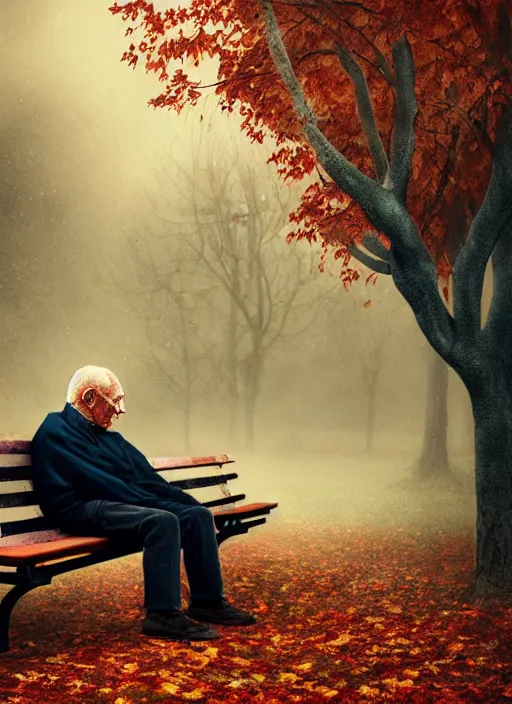

In [3]:
image, output = caption_image(f'https://cdn.openart.ai/stable_diffusion/0a0d6ed4d409e2192eed21464104f43bd5dbaaaa_2000x2000.webp', 'Describe the image and color details.')
print(output)
image